## IMPORT TOOLS AND LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay

from joblib import dump, load

pd.set_option("display.width", 1000000000)
randomseed = 15

## DATA HANDLING

##### IMPORT AND SHUFFLE DATA

In [2]:
heartDiseaseData = pd.read_csv("heart-disease.csv")
heartDisease = pd.DataFrame(heartDiseaseData).sample(frac=1, random_state=randomseed)
heartDisease = heartDisease.drop("fbs", axis=1)  # REMOVE DATA THAT DOES NOT CORRELATE WITH TARGET

In [3]:
heartDisease

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,target
201,60,1,0,125,258,0,141,1,2.8,1,1,3,0
197,67,1,0,125,254,1,163,0,0.2,1,2,3,0
64,58,1,2,140,211,0,165,0,0.0,2,0,2,1
134,41,0,1,126,306,1,163,0,0.0,2,0,2,1
145,70,1,1,156,245,0,143,0,0.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,65,1,0,110,248,0,158,0,0.6,2,2,1,0
155,58,0,0,130,197,1,131,0,0.6,1,0,2,1
156,47,1,2,130,253,1,179,0,0.0,2,0,2,1
133,41,1,1,110,235,1,153,0,0.0,2,0,2,1


##### SPLIT DATA INTO TRAIN, VALIDATION AND TEST SETS

In [4]:
train_index = round(0.7 * len(heartDisease))
valid_index = round(0.85 * len(heartDisease))

train_data = heartDisease.iloc[:train_index]
valid_data = heartDisease.iloc[train_index:valid_index]
test_data = heartDisease.iloc[valid_index:]

print(f'''Total Number of Rows in Data: {len(heartDisease)}
Number of Rows in Training Data: {len(train_data)}
Number of Rows in Validation Data: {len(valid_data)}
Number of Rows in Test Data: {len(test_data)}''')

Total Number of Rows in Data: 303
Number of Rows in Training Data: 212
Number of Rows in Validation Data: 46
Number of Rows in Test Data: 45


##### SPLIT DATA INTO X AND Y

In [5]:
X, y = heartDisease.drop("target", axis=1), heartDisease["target"]
X_train, y_train = train_data.drop("target", axis=1), train_data["target"]
X_valid, y_valid = valid_data.drop("target", axis=1), valid_data["target"]
X_test, y_test = test_data.drop("target", axis=1), test_data["target"]

## TRAIN AND CONDUCT INITIAL MODEL TEST

##### TRAIN RANDOMFOREST MODEL

In [6]:
randForestModel = RandomForestClassifier(n_jobs=-1)
randForestModel.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

##### TRAIN KNEIGHBOURS MODEL

In [7]:
kNeighbModel = KNeighborsClassifier(n_jobs=-1)
kNeighbModel.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

##### TRAIN LOGISTIC REGRESSION MODEL

In [8]:
logRegModel = LogisticRegression(n_jobs=-1)
logRegModel.fit(X_train, y_train)

LogisticRegression(n_jobs=-1)

##### CREATE FUNCTION TO EVALUATE MODELS

In [9]:
def evaluate_results(models, xtest, ytest):

    model_accuracy = {}
    model_precision = {}
    model_recall = {}
    model_f1 = {}
    model_rocauc = {}

    for name, model in models.items():
        print(f"Testing {name} Model...")
        ypred = model.predict(xtest)
        model_accuracy[name] = accuracy_score(ytest, ypred)
        model_precision[name] = precision_score(ytest, ypred)
        model_recall[name] = recall_score(ytest, ypred)
        model_f1[name] = f1_score(ytest, ypred)
        model_rocauc[name] = roc_auc_score(ytest, ypred)
    
    return [model_accuracy, model_precision, model_recall, model_f1, model_rocauc]

##### INITIALISE MODELS

In [10]:
initial_models = {"RandomForestClassifier": randForestModel,
                  "KNeighborsClassifier": kNeighbModel,
                  "LogisticRegression": logRegModel}

##### INITIAL MODEL PARAMETERS

In [11]:
print(f'''RandomForestClassifier-----------------
{pd.DataFrame(initial_models["RandomForestClassifier"].get_params(), index=["Parameters"]).transpose()}

KNeighborsClassifier-------------------
{pd.DataFrame(initial_models["KNeighborsClassifier"].get_params(), index=["Parameters"]).transpose()}

LogisticRegression---------------------
{pd.DataFrame(initial_models["LogisticRegression"].get_params(), index=["Parameters"]).transpose()}''')

RandomForestClassifier------------
                         Parameters
bootstrap                      True
ccp_alpha                       0.0
class_weight                   None
criterion                      gini
max_depth                      None
max_features                   auto
max_leaf_nodes                 None
max_samples                    None
min_impurity_decrease           0.0
min_samples_leaf                  1
min_samples_split                 2
min_weight_fraction_leaf        0.0
n_estimators                    100
n_jobs                           -1
oob_score                     False
random_state                   None
verbose                           0
warm_start                    False

KNeighborsClassifier--------------
              Parameters
algorithm           auto
leaf_size             30
metric         minkowski
metric_params       None
n_jobs                -1
n_neighbors            5
p                      2
weights          uniform

LogisticRegression-

##### TRAIN MODELS AND CONDUCT INITIAL TEST

In [12]:
initial_results = evaluate_results(initial_models, X_valid, y_valid)
initial_results_DF = pd.DataFrame(initial_results, index=["Accuracy", "Precision", "Recall", "F1", "ROCAUC"])

Testing RandomForestClassifier Model...
Testing KNeighborsClassifier Model...
Testing LogisticRegression Model...


##### CREATE FUNCTION TO VISUALISE TEST RESULTS

In [13]:
def visualise_results(results):
    print(results)
    results_bar = results.plot.bar(figsize=(17, 8), xlabel="Scoring Method", ylabel="Model Score", title="Results of Models")
    results_bar.legend(title="Model Type", bbox_to_anchor=(1.01, 1));

##### VISUALISE AND COMPARE INITIAL TEST RESULTS

Initial Test Results
           RandomForestClassifier  KNeighborsClassifier  LogisticRegression
Accuracy                 0.913043              0.565217            0.913043
Precision                0.862069              0.586207            0.888889
Recall                   1.000000              0.680000            0.960000
F1                       0.925926              0.629630            0.923077
ROCAUC                   0.904762              0.554286            0.908571


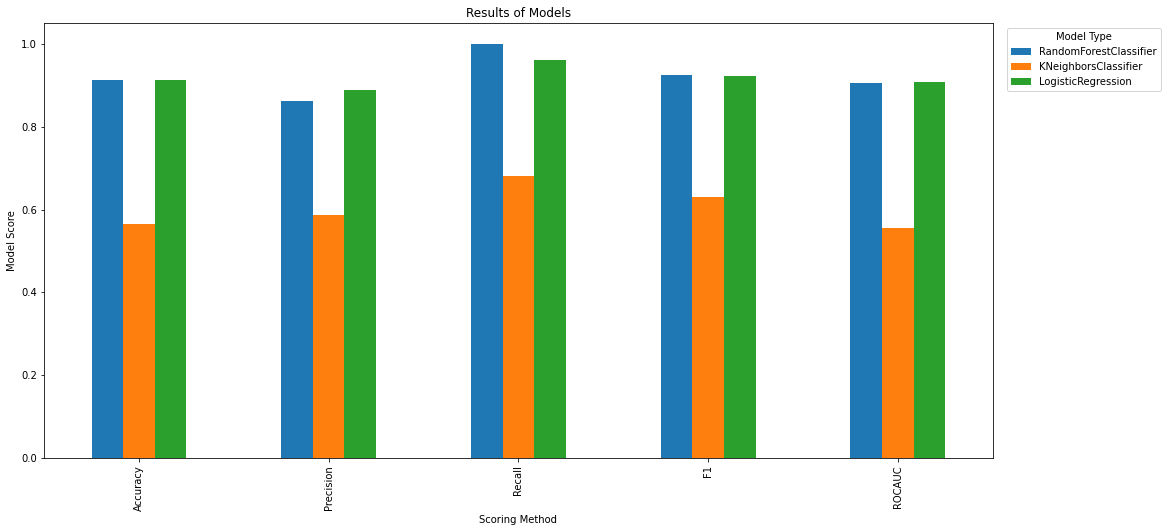

In [14]:
print("Initial Test Results")
visualise_results(initial_results_DF)

## TUNE AND RE-TEST MODELS

##### RANDOMFOREST CLASSIFIER MODEL

In [15]:
gs_randForest_grid = {"n_estimators": [700, 800, 900],
                      "max_features": ["auto", "sqrt"],
                      "max_depth": [3, 4, 5],
                      "min_samples_split": [8, 9, 10],
                      "bootstrap": [True, False]}
gs_randForest = GridSearchCV(estimator=initial_models["RandomForestClassifier"],
                             param_grid=gs_randForest_grid,
                             cv=5,
                             verbose=1,
                             n_jobs=-1)
gs_randForest.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [8, 9, 10],
                         'n_estimators': [700, 800, 900]},
             verbose=1)

##### LOGISTIC REGRESSION MODEL

In [16]:
gs_logReg_grid = {"C": [0.1, 0.3, 0.5],
                  "max_iter": [i for i in range(45, 50)]}
gs_logReg = GridSearchCV(estimator=initial_models["LogisticRegression"],
                         param_grid=gs_logReg_grid,
                         cv=5,
                         verbose=1,
                         n_jobs=-1)
gs_logReg.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1), n_jobs=-1,
             param_grid={'C': [0.1, 0.3, 0.5],
                         'max_iter': [45, 46, 47, 48, 49]},
             verbose=1)

##### KNEIGHBOURS MODEL
- WILL NO LONGER BE USED AS IT SCORED TOO POORLY IN INITIAL TEST

##### INITIALISE TUNED MODELS

In [17]:
tuned_models = {"RandomForestClassifier": gs_randForest,
                "LogisticRegression": gs_logReg}

##### TRAIN AND TEST TUNED MODELS

In [18]:
tuned_results = evaluate_results(tuned_models, X_valid, y_valid)
tuned_results_DF = pd.DataFrame(tuned_results, index=["Accuracy", "Precision", "Recall", "F1", "ROCAUC"])

Testing RandomForestClassifier Model...
Testing LogisticRegression Model...


##### VISUALISE TUNED RESULTS

Tuned Results:
           RandomForestClassifier  LogisticRegression
Accuracy                 0.934783            0.913043
Precision                0.892857            0.862069
Recall                   1.000000            1.000000
F1                       0.943396            0.925926
ROCAUC                   0.928571            0.904762


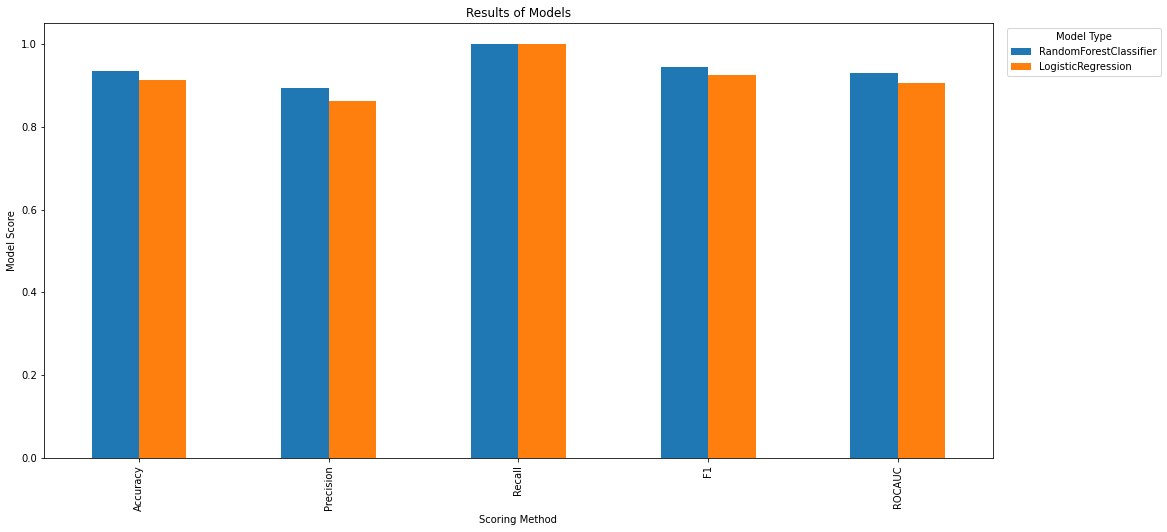

In [19]:
print("Tuned Results:")
visualise_results(tuned_results_DF)

##### BEST MODEL PARAMETERS

In [20]:
print(f'''RandomForestClassifier-----------------
{pd.DataFrame(gs_randForest.best_params_, index=["Parameters"]).transpose()}

LogisticRegression---------------------
{pd.DataFrame(gs_logReg.best_params_, index=["Parameters"]).transpose()}''')

RandomForestClassifier------------
                  Parameters
bootstrap               True
max_depth                  3
max_features            sqrt
min_samples_split         10
n_estimators             700
LogisticRegression----------------
          Parameters
C                0.3
max_iter        48.0


## MODEL EVALUATION AND SUMMARY

##### INITIALISE THE FINAL MODEL
- RANDOMFORESTCLASSIFIER WILL BE SELECTED AS THE FINAL MODEL SINCE IT OUTPERFORMS LOGISTICREGRESSION AFTER TUNING

In [21]:
final_model = {"RandomForestClassifier": gs_randForest}

##### TEST FINAL MODEL

In [22]:
final_result = evaluate_results(final_model, X_test, y_test)
final_result_DF = pd.DataFrame(final_result, index=["Accuracy", "Precision", "Recall", "F1", "ROCAUC"])

Testing RandomForestClassifier Model...


##### VISUALISE THE FINAL RESULTS OF THE MODEL

Final Results:
           RandomForestClassifier
Accuracy                 0.866667
Precision                0.833333
Recall                   0.961538
F1                       0.892857
ROCAUC                   0.849190


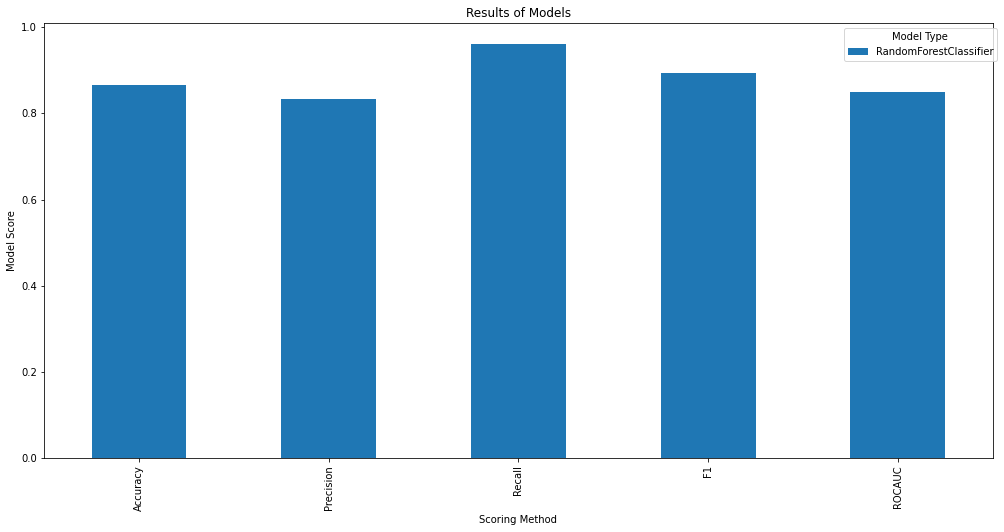

In [23]:
print("Final Results:")
visualise_results(final_result_DF)

##### MODEL ROC CURVE

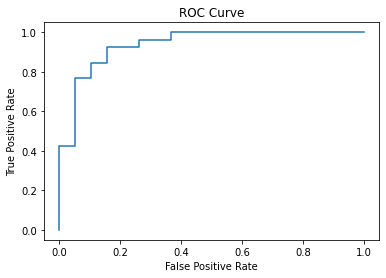

In [24]:
y_pred_proba = gs_randForest.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");

##### MODEL CONFUSION MATRIX

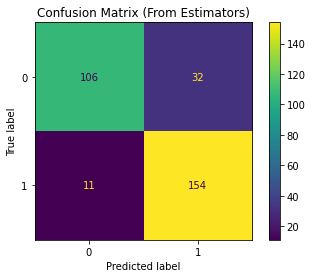

In [25]:
ConfusionMatrixDisplay.from_estimator(estimator=gs_logReg, X=X, y=y)
plt.title("Confusion Matrix (From Estimators)");

##### MODEL CLASSIFICATION REPORT

In [26]:
ypred = gs_randForest.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.83      0.96      0.89        26

    accuracy                           0.87        45
   macro avg       0.88      0.85      0.86        45
weighted avg       0.88      0.87      0.86        45



## SAVE AND LOAD MODEL

##### SAVE MODEL

In [27]:
dump(gs_logReg, filename="HeartDiseaseModel.joblib")

['HeartDiseaseModel.joblib']

##### LOAD MODEL

In [28]:
heartDiseaseModel = load(filename="HeartDiseaseModel.joblib")

##### ENSURE MODEL LOADED SUCCESSFULLY

In [29]:
loaded_model_ypred = heartDiseaseModel.predict(X_test)
print(classification_report(y_test, loaded_model_ypred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.89      0.92      0.91        26

    accuracy                           0.89        45
   macro avg       0.89      0.88      0.89        45
weighted avg       0.89      0.89      0.89        45



In [30]:
!streamlit run ./HeartDiseasePredictionApp.py

^C
